#0-作業環境の準備

##0.1. Google Driveをマウント

##0.2. ディレクトリの移動

In [1]:
%cd /content/drive/MyDrive/研究室/研究_M2/src

/content/drive/MyDrive/研究室/研究_M2/src


##0.3. 時刻を取得

In [2]:
import datetime
from pytz import timezone

def Pull_Datetime():
    dates=datetime.datetime.now(timezone('Asia/Tokyo'))
    exept_microsec=dates.strftime("%Y-%m-%d-%H-%M")
    print('[Today : %s]' % str(exept_microsec))

    DATETIME=exept_microsec
    return DATETIME

DATETIME=Pull_Datetime()

[Today : 2021-08-20-00-18]


##0.4. 各種フォルダ・ファイル名を作成

In [3]:
import os
OUTPUT_PATH =  './Assets/Assets_Output/'
OUTPUT_DIR=OUTPUT_PATH+ "PersonalEstim_%s/" % DATETIME
OUTPUT_DIR_RESULTS=OUTPUT_PATH+ "PersonalEstim_%s/results/" % DATETIME

KEYWORDS_TypeMBTI = '2017-2018'

try:
  os.mkdir(OUTPUT_DIR)
except:
  print(OUTPUT_DIR, '    already exists')
  print()
try:
  os.mkdir(OUTPUT_DIR_RESULTS)
except:
  print(OUTPUT_DIR_RESULTS, '    the directory already exists')
  print()

In [4]:
 KEYWORDS_FileName='2017-2018'



---



#1-twitter からテキストマイニング

よっしーさんのTwitter APIの解説回

https://drive.google.com/file/d/1nmcdd0PgFp5cKjSVQsIGPeb1soZF_vo4/view

##1.1.ツイートの検索条件を指定

In [ ]:
#Inputs for the request
keyword = "#16Personalities 16personalities.com lang:ja"
start_time = "2017-01-01T00:00:00.000Z"
end_time = "2018-12-31T00:00:00.000Z"
max_results = 500
next_token = None

##1.2. Twitter APIに接続するURLを作成する関数

In [6]:
import yaml
import os # For saving access tokens and for file management when creating and adding to the dataset
import requests # For sending GET requests from the API
import Twitter_API_Key

def Create_url_SearchTweets(keyword, start_date, end_date, max_results = 10):
    #Change to the endpoint you want to collect data from
    search_url = "https://api.twitter.com/2/tweets/search/all" 
    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
                    
    return (search_url, query_params)

##1.3.Twitter APIに接続する関数

In [7]:
def Connect_to_endpoint(url, params, next_token = None):
    #prepare params
    params['next_token'] = next_token   #params object received from create_url function
    #pull bearer token
    bearer_token = Twitter_API_Key.Auth_FullAchieve()
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    #request Twtitter
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
        
    return response.json()

##1.4. 特定のハッシュタグでツイートするアカウント一覧の取得

In [9]:
import dateutil.parser
import pandas as pd

def Search_Tweets(keyword, start_time, end_time, max_results, next_token, KEYWORDS_FileName):
  url = Create_url_SearchTweets(keyword, start_time, end_time, max_results)
  print(url)
  json_SearchTweets= Connect_to_endpoint(url[0], url[1], next_token)
  # json_SearchTweets
  # print(json_SearchTweets)
  list_EachData=json_SearchTweets['data']

  list_csv=[]
  list_csv.clear()
  list_header=['author_id', 'text', 'tweet_time', 'tweet_id', 'lang']
  for element in list_EachData:
    #print(element['text'])
    tweet_AuthorID=element['author_id']
    tweet_Texts=element['text']
    tweet_id = element['id']
    tweet_time = dateutil.parser.parse(element['created_at'])
    tweet_lang = element['lang']

    list_sub_row=[tweet_AuthorID, tweet_Texts, tweet_id, tweet_time, tweet_lang]
    list_csv.append(list_sub_row)

  df_SearchTweets=pd.DataFrame(list_csv, columns=list_header)
  df_SearchTweets.to_csv('%sUserList_%s.csv' % (OUTPUT_DIR_RESULTS, KEYWORDS_FileName))

  return df_SearchTweets

df_SearchTweets=Search_Tweets(keyword, start_time, end_time, max_results, next_token, KEYWORDS_TypeMBTI)
list_AuthorID=df_SearchTweets['author_id'].to_list()

NameError: ignored

##1.5. 念の為、確認する。

In [ ]:
list_AuthorID

df_SearchTweets

,author_id,text,tweet_time,tweet_id,lang
0,2489860807,私の性格タイプは “仲介者” です。あなたのタイプは何ですか？ https://t.co/x...,1079522145380626432,2018-12-30 23:38:30+00:00,ja
1,820565738700165120,2回やって2回ともこれだったから間違いなくこれなんだろーな。\n\n私の性格タイプは “論理...,1079502918397583360,2018-12-30 22:22:06+00:00,ja
2,827450414756802560,私の性格タイプは “仲介者” です。あなたのタイプは何ですか？ https://t.co/t...,1079436425488023552,2018-12-30 17:57:53+00:00,ja
3,95916992,私の性格タイプは “擁護者” です。あなたのタイプは何ですか？ https://t.co/7...,1079397749907279873,2018-12-30 15:24:12+00:00,ja
4,1076633479,シェア出来なくて消えてしまった…\n「広報運動家」だった\n\n無料性格診断テスト http...,1079384744868044802,2018-12-30 14:32:31+00:00,ja
...,...,...,...,...,...
489,459313182,私の性格タイプは “仲介者” です。あなたのタイプは何ですか？ https://t.co/i...,1074946820554379264,2018-12-18 08:37:48+00:00,ja
490,783913580,私の性格タイプは “仲介者” です。あなたのタイプは何ですか？ https://t.co/y...,1074939640468037632,2018-12-18 08:09:16+00:00,ja
491,2665164444,私の性格タイプは “論理学者” です。あなたのタイプは何ですか？ https://t.co/...,1074938024373276672,2018-12-18 08:02:51+00:00,ja
492,4084050373,私の性格タイプは “広報運動家” です。あなたのタイプは何ですか？ https://t.co...,1074917760432463873,2018-12-18 06:42:19+00:00,ja


#2-特定のユーザーから過去のツイートを取得する。

各個人につき、1024件の投稿を取得する。

##2.1. Twitter APIに接続するURLを作成する関数

In [13]:
import yaml
import os # For saving access tokens and for file management when creating and adding to the dataset
import requests # For sending GET requests from the API
import Twitter_API_Key

def Create_url_UserTimeline(list_AuthorID, start_date, end_date, max_results = 10):
    #Change to the endpoint you want to collect data from
    search_url = "https://api.twitter.com/2/users/%s/tweets" % list_AuthorID
    #change params based on the endpoint you are using
    query_params = {'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {},
                    'start_time': start_date,
                    'end_time': end_date
                    }
                    
    return (search_url, query_params)

##2.2. 特定のユーザーから過去のツイートを取得する関数

In [46]:
import dateutil.parser
import pandas as pd
import tqdm

def Pull_tweets_from_specific_users(list_AuthorID, start_time, end_time, max_results, next_token, OUTPUT_DIR_RESULTS, KEYWORDS_TypeMBTI):
  url = Create_url_UserTimeline(list_AuthorID, start_time, end_time, max_results)
  json_UserTimeline= Connect_to_endpoint(url[0], url[1], next_token)

  json_UserTimeline
  print(json_UserTimeline)
  list_dict_keys=list(json_UserTimeline.keys())
  if list_dict_keys[0]=='errors':
    return 0
  elif json_UserTimeline['meta']['result_count']==0:
    return 0
  else: 
    list_EachData=json_UserTimeline['data']
    

  list_csv=[]
  list_csv.clear()
  list_header=['author_id', 'text',  'tweet_id','tweet_time', 'conversation_id','lang']
  for element in list_EachData:
    #print(element['text'])
    tweet_AuthorID=element['author_id']
    tweet_Texts=element['text']
    tweet_id = element['id']
    tweet_time = dateutil.parser.parse(element['created_at'])
    convarsation_id = element['conversation_id']
    tweet_lang = element['lang']

    list_sub_row=[tweet_AuthorID, tweet_Texts, tweet_id, tweet_time, convarsation_id, tweet_lang]
    list_csv.append(list_sub_row)

  df_UserTimeline=pd.DataFrame(list_csv, columns=list_header)
  df_UserTimeline.to_csv('%sTweetsByOneUser_%s_%s.csv' % (OUTPUT_DIR_RESULTS, KEYWORDS_TypeMBTI, df_UserTimeline['author_id'][0]))

  return df_UserTimeline

##2.3. 関数を動かして特定のユーザーから過去のツイートを取得する。

In [43]:
df_2017=pd.read_csv('/content/drive/MyDrive/研究室/研究_M2/src/Assets/Assets_Output/Tweet_Datasets/Tweet__MBTI_2017.csv')
list_AuthorID=df_2017['author_id'].values.tolist()
list_AuthorID=list(map(int, list_AuthorID))
print(len(list_AuthorID))

36277


In [44]:
list_AuthorID=set(list_AuthorID)
print(len(list_AuthorID))

33996


In [49]:
  KEYWORDS_FileName='2017-2018'

In [1]:
next_token=None
max_results_author=100
start_time = "2017-01-01T00:00:00.000Z"
end_time = "2017-12-31T23:59:50.000Z"

for idx, element_AuthorID in enumerate(list_AuthorID):
  print(idx, "：", element_AuthorID)
  FileName=KEYWORDS_FileName+"_"+str(idx)
  Pull_tweets_from_specific_users(element_AuthorID, start_time, end_time, max_results_author, next_token, OUTPUT_DIR_RESULTS,  FileName)

NameError: ignored

In [40]:
a={'errors': [{'value': '760068656906633216', 'detail': 'Could not find user with id: [760068656906633216].', 'title': 'Not Found Error', 'resource_type': 'user', 'parameter': 'id', 'resource_id': '760068656906633216', 'type': 'https://api.twitter.com/2/problems/resource-not-found'}]}
print(type(a))
print(list(a.keys()))

<class 'dict'>
['errors']




---



#3-ツイート一覧から頻出単語を調べる。

https://qiita.com/pocket_kyoto/items/9bff8f253c9122a82128

##2.0. 形態素解析ツールのダウンロード

In [ ]:
!pip install janome

     |████████████████████████████████| 19.7MB 1.4MB/s 


##2.1. 形態素解析の実施と頻出単語を調べる。

頻出単語について、ひらがなは除外しました。

In [ ]:
# 文章を形態素解析して、Bag of Wordsに変換する
from janome.tokenizer import Tokenizer
import collections
import re

def CountWord(tweet_list):
    all_tweet = "\n".join(tweet_list)

    t = Tokenizer()

    # 原形に変形、名詞のみ、1文字を除去、漢字・平仮名・カタカナの連続のみに限定
    c = collections.Counter(token.base_form for token in tqdm(t.tokenize(all_tweet))
                            if token.part_of_speech.startswith('名詞') and len(token.base_form) > 1 
                            and token.base_form.isalpha() and not re.match('^[a-zA-Z]+$', token.base_form)) 
    # for token in tqdm(t.tokenize(all_tweet)):
    #   if token.part_of_speech.startswith('名詞') and len(token.base_form) > 1 and token.base_form.isalpha() and not re.match('^[a-zA-Z]+$', token.base_form):
    #     c = collections.Counter(token.base_form)

    pre_dict_freq = {}
    mc = c.most_common()
    for elem in mc:
        pre_dict_freq[elem[0]] = elem[1]

    list_freq=list(pre_dict_freq)
    #print(list_c)
    #print(c)
    for idx, ch in enumerate(list_freq[:100]):
        if not (ch < u'ぁ' or ch > u'ん') and ch != '_': #ひらがなの場合
          #print(ch)
          del pre_dict_freq["%s" % ch]
        else:
          pass
    #print() 

    dict_freq=pre_dict_freq
    return dict_freq


dict_word_freq_INFJ = CountWord(list_INFJ)
dict_word_freq_ENFJ = CountWord(list_ENFJ)
print(dict_word_freq_ENFJ)


{'好き': 136, '自分': 136, '今日': 113, '時間': 83, '誕生': 82, 'ユベル': 82, '世界': 77, '先生': 75, '感じ': 67, 'イラスト': 65, '人間': 62, '漫画': 59, 'キャラ': 58, '素敵': 55, '遊戯': 55, 'ゲーム': 54, '公開': 54, '一緒': 53, '作品': 52, '開催': 52, '言葉': 49, '仕事': 48, '実装': 47, 'アゼル': 47, '最近': 45, '気持ち': 43, '動画': 43, 'ーー': 43, '大好き': 41, '商品': 40, '本当': 40, '希望': 39, '聖戦': 39, 'アニメ': 37, '登場': 37, 'ツイート': 37, '今回': 36, '発売': 36, '確か': 36, '英雄': 36, 'インク': 36, '情報': 35, '子供': 35, '名前': 35, '一番': 35, '楽しみ': 35, '意味': 35, 'ティルテュ': 34, '個人': 33, '明日': 33, '日本': 33, '投票': 33, '風花': 33, '配信': 32, '水着': 32, 'プレイ': 32, '皆さん': 32, 'アゼティル': 32, '映画': 31, '今年': 31, '普通': 31, '息子': 31, 'パル': 31, '価値': 30, 'カス': 30, 'アッシュ': 30, '可能': 29, 'コロナ': 29, '人生': 29, '最終': 29, 'タル': 29, 'アンケート': 29, 'メガホビ': 29, 'アカウント': 28, '大丈夫': 28, '絶対': 28, '大変': 27, 'カラー': 27, 'ーーー': 27, '写真': 26, '時代': 26, '最後': 26, 'カード': 26, 'レベル': 25, 'ペン': 25, '以上': 24, '本日': 24, '水彩': 24, '昨日': 24, '問題': 24, 'タイプ': 24, '毎日': 23, 'とこ': 23, '創作': 23, '表現': 23, '関係': 2

##2.2. 頻出単語をwordcloudで可視化

In [ ]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 2s (4,437 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-18ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-18ubuntu1) ...
Selecting previously unselected package fonts-ip

INFJ
{'モデル': 310, '油彩': 282, '被写体': 245, '好き': 178, '自分': 152, '募集': 135, '作品': 128, '時間': 120, '肖像': 116, '今日': 94, 'キリトリセカイ': 83, '感じ': 82, '表現': 72, '写真': 69, 'ｷﾞｭｯ': 62, 'ペット': 61, '仕事': 57, '完成': 56, '部分': 56, '人間': 54, '注文': 47, '質問': 46, 'ポートレート': 43, '依頼': 41, '明日': 39, '必要': 38, '制作': 37, 'ストレス': 36, '世界': 35, '最近': 35, '風呂': 35, '詳細': 34, '一番': 34, '油絵': 34, '表情': 33, '気圧': 33, '掲載': 33, 'ダメ': 32, '加筆': 32, '予定': 29, '昨日': 29, 'タイプ': 29, '気持ち': 29, '大切': 29, '開始': 29, '意味': 28, '言葉': 28, '子供': 28, '結果': 28, '感謝': 27, '無理': 26, '丁寧': 26, '大事': 26, '最高': 26, 'バック': 26, '動画': 25, 'ブログ': 25, 'ﾎﾟｯｸﾙ': 24, '女性': 24, '大変': 24, '以上': 24, 'プロフィール': 24, '関係': 23, '人生': 23, '人物': 23, '問い合わせ': 23, '普通': 22, '日本': 22, '状態': 22, '場合': 22, 'ツイート': 21, 'ご飯': 21, '終了': 21, 'すべて': 21, 'イメージ': 21, 'ゲーム': 21, 'どこ': 21, '通り': 21, 'おすすめ': 21, 'ﾅﾃﾞﾅﾃﾞ': 20, '一緒': 20, '存在': 20, '周り': 20, '文字': 20, '可能': 20, '最初': 20, '感覚': 20, 'つもり': 20, '過程': 20, '毛並み': 20, 'なに': 19, 'むぽむぅ': 19, '情報': 19, '名前': 19,

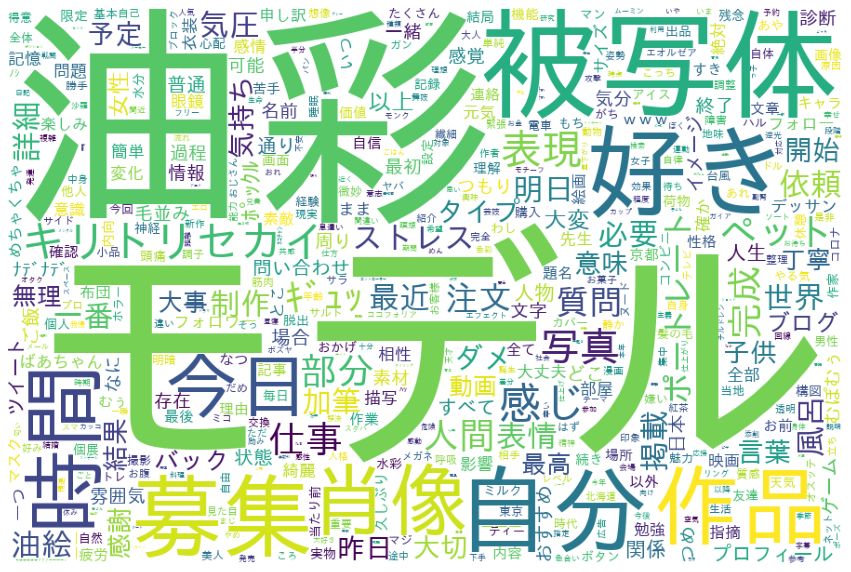


ENFJ
{'好き': 136, '自分': 136, '今日': 113, '時間': 83, '誕生': 82, 'ユベル': 82, '世界': 77, '先生': 75, '感じ': 67, 'イラスト': 65, '人間': 62, '漫画': 59, 'キャラ': 58, '素敵': 55, '遊戯': 55, 'ゲーム': 54, '公開': 54, '一緒': 53, '作品': 52, '開催': 52, '言葉': 49, '仕事': 48, '実装': 47, 'アゼル': 47, '最近': 45, '気持ち': 43, '動画': 43, 'ーー': 43, '大好き': 41, '商品': 40, '本当': 40, '希望': 39, '聖戦': 39, 'アニメ': 37, '登場': 37, 'ツイート': 37, '今回': 36, '発売': 36, '確か': 36, '英雄': 36, 'インク': 36, '情報': 35, '子供': 35, '名前': 35, '一番': 35, '楽しみ': 35, '意味': 35, 'ティルテュ': 34, '個人': 33, '明日': 33, '日本': 33, '投票': 33, '風花': 33, '配信': 32, '水着': 32, 'プレイ': 32, '皆さん': 32, 'アゼティル': 32, '映画': 31, '今年': 31, '普通': 31, '息子': 31, 'パル': 31, '価値': 30, 'カス': 30, 'アッシュ': 30, '可能': 29, 'コロナ': 29, '人生': 29, '最終': 29, 'タル': 29, 'アンケート': 29, 'メガホビ': 29, 'アカウント': 28, '大丈夫': 28, '絶対': 28, '大変': 27, 'カラー': 27, 'ーーー': 27, '写真': 26, '時代': 26, '最後': 26, 'カード': 26, 'レベル': 25, 'ペン': 25, '以上': 24, '本日': 24, '水彩': 24, '昨日': 24, '問題': 24, 'タイプ': 24, '毎日': 23, 'とこ': 23, '創作': 23, '表現': 23, '関

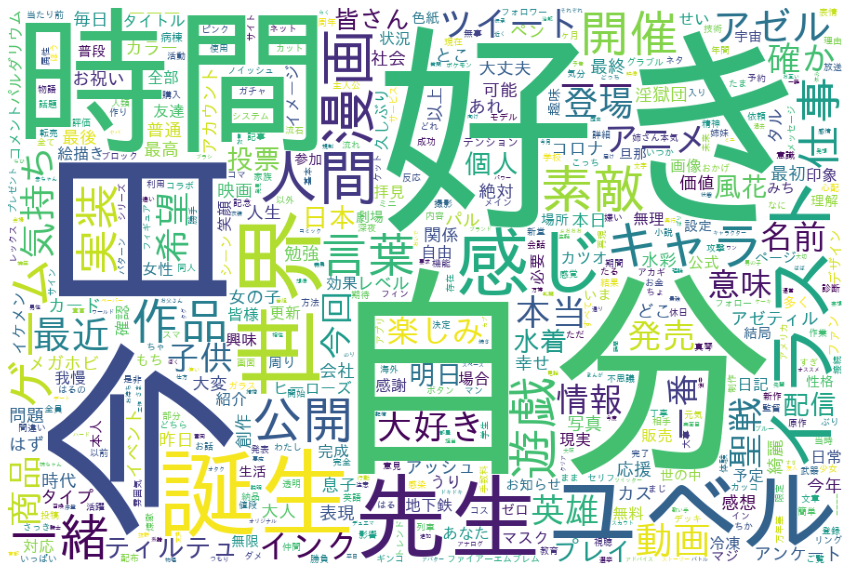

In [ ]:
# Word Cloudで可視化、WordCloud可視化関数
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def make_cloud(dict_word_freq, name_16type):
  print(name_16type)
  print(dict_word_freq)
  fpath = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # 日本語フォント指定

  stop_words = ['さん','そう'] 
  wordcloud = WordCloud(
      font_path=fpath,
      width=900, height=600,   # default width=400, height=200
      background_color="white",   # default=”black”
      stopwords=set(stop_words),
      max_words=500,   # default=200
      min_font_size=4,   #default=4
      collocations = False   #default = True
      ).fit_words(dict_word_freq) #https://water2litter.net/rum/post/python_wordcloud_fit/
  
  plt.figure(figsize=(15,12))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.savefig("word_cloud_%s.png" %  name_16type)
  plt.show()

  print()
make_cloud(dict_word_freq_INFJ, "INFJ")
make_cloud(dict_word_freq_ENFJ, "ENFJ")
#DrawWordCloud(dict_word_freq_ENFJ , "ENFJ")

#今後の予定

性格分析対象の人数を増やす

*   今は外交的な人物と内向的な人物で5人ずつしかない
*   先行研究は4,000人と15,000人いた。(データの偏りあり)

精度を高める

* 特徴量の抽出にBERTを利用してはどうか。

形態素解析について

* SNSの投稿のような短い文書にはSentencePieceという情報もあった。

